### Task 1  



Q1) C  
Q2) C  
Q3) C  
Q4) B  
Q5) D  
Q6) C  
Q7) C  
Q8) C  
Q9) C  
Q10) D  
Q11) D  
Q12) D  
Q13) C  
Q14) A

### Task 2

#### Part 1

In [118]:
#load the CSV dataset into a pandas Dataframe 
import pandas as pd 

data = pd.read_csv("ecommerce_data.csv")

In [17]:
#exporatory data analysis
data.describe()

,CustomerID,ProductID,Price,Quantity
count,1000.000000,1000.000000,900.000000,1000.000000
mean,1050.128000,10.338000,257.705579,2.975000
std,29.573505,5.771921,144.306057,1.414346
min,1001.000000,1.000000,10.092316,1.000000
25%,1024.000000,5.000000,130.849891,2.000000
50%,1051.000000,10.000000,266.021046,3.000000
75%,1075.000000,15.000000,382.361857,4.000000
max,1100.000000,20.000000,499.859764,5.000000


In [140]:
data.isnull().sum()

CustomerID      0
Timestamp       0
ProductID       0
Category      100
Price         100
Quantity        0
Action          0
dtype: int64

In [24]:
#Handle for missing data 
#check the amount of missingness 


print(data.isnull().sum())


CustomerID      0
Timestamp       0
ProductID       0
Category      100
Price         100
Quantity        0
Action          0
dtype: int64


<Axes: >

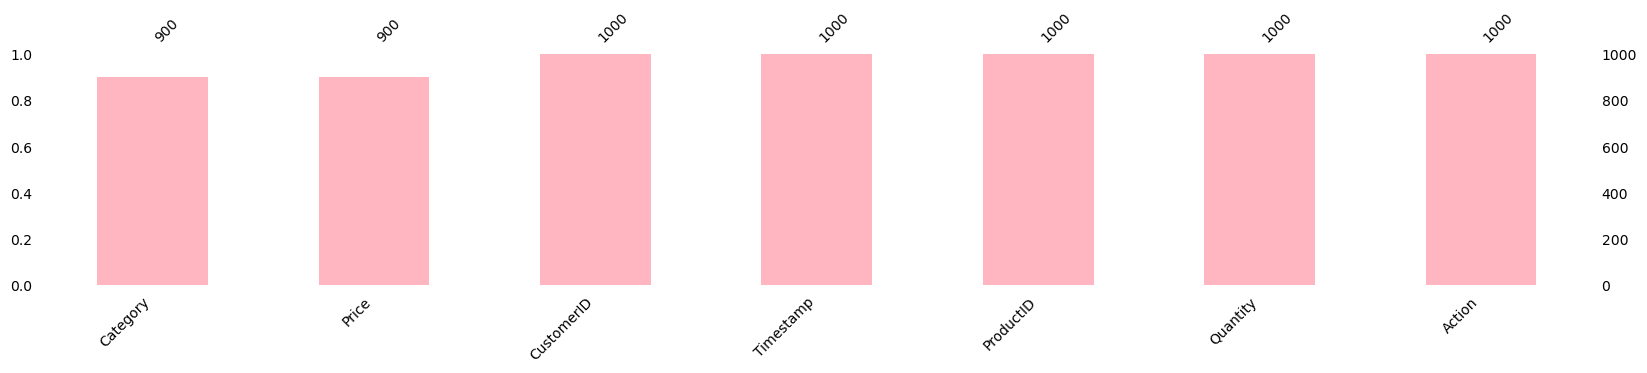

In [40]:
import missingno as msno 
msno.bar(data, color = "lightpink", sort = "ascending", figsize = (20,3), fontsize=(10))

category and price accounts for only 10% of missingness from each feature. In this case, we can either remove 100 rows of missing values or fill in the missingness with imputation. 

Strategy_1: Get rid of 100 rows of data reducing the total dataset to 900 samples

In [162]:
import copy 
data_undersample = copy.deepcopy(data)
data_undersample.dropna(axis = 0, inplace = True) 

Strategy_2: Replace the missing values with the mode or the mean but before that we check the distribution of the category throughout the e-commerce site 

In [229]:
import matplotlib.pyplot as plt 
category_counts = data['Category'].value_counts()

quantity_ratio_category = {
    "Clothing": round((category_counts["Clothing"] / category_counts.sum()) * 100, 2),
    "Books": round((category_counts["Books"] / category_counts.sum()) * 100, 2),
    "Home": round((category_counts["Home"] / category_counts.sum()) * 100, 2),
    "Electronics": round((category_counts["Electronics"] / category_counts.sum()) * 100, 2)
}

quantity_ratio_category


{'Clothing': 26.56, 'Books': 25.0, 'Home': 22.44, 'Electronics': 26.0}

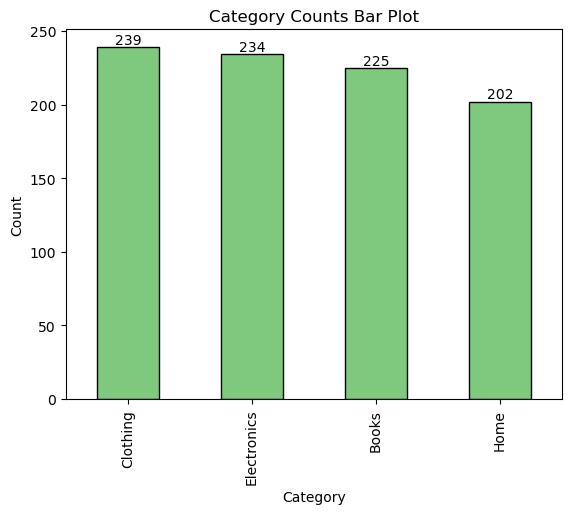

In [206]:
ax = category_counts.plot(kind='bar', colormap='Accent', edgecolor = "black")

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts Bar Plot')

for index, value in enumerate(category_counts):
    ax.text(index, value, str(value), ha='center', va='bottom')
plt.show()

Since the missing values we are trying to replace are categorical. This cannot be replace by the mean or median, so the logical option would be mode.

In [136]:
#checking if the quantity of the products provide me with any information regarding the missing category  
data.groupby('Category')['Quantity'].aggregate('mean')

Category
Books          2.928889
Clothing       3.020921
Electronics    2.970085
Home           3.009901
Name: Quantity, dtype: float64

In [149]:
#observe the action that take place the most for each of these categories
cross_tab = pd.crosstab(data['Category'], data['Action'])
cross_tab

Action,Add to Cart,Purchase,View
Category,,,
Books,75,76,74
Clothing,94,66,79
Electronics,0,234,0
Home,71,60,71


Now we know if an action is purchase there is greater likelihood of the category being electronics, the most viewed and added to cart items are clothing. Books and home category have random actions  

In [161]:
#Now we check the count of each action in the missing category rows 
action_counts ={}
actions = data['Action']
for action in actions:
    filtered_data = data[(data['Action'] == action) & (data['Category'].isna())]
    count = len(filtered_data)
    action_counts[action] = count 
print(action_counts)

{'Add to Cart': 31, 'View': 39, 'Purchase': 30}


30 Null rows from category column that matches the action is purchase will be filled with electronics, since the action of purchase was most conducted on electronics category. 31 rows(Action:Add to cart) will be filled with clothing. View has the most Null values, this could be imputed with books and home at random.  


In [191]:
import numpy as np 
np.random.seed(42)
data_oversample= copy.deepcopy(data)
data_oversample['Category'] = np.where((data['Action'] == 'Purchase') & (data['Category'].isna()), 'Electronics', data['Category'])
data_oversample['Category'] = np.where((data['Action'] == 'Add to Cart') & (data['Category'].isna()), 'Clothing', data['Category'])
data_oversample['Category'] = np.where(data_oversample['Category'].isna(), np.random.choice(np.array (['Books', 'Home']), len(data_oversample['Category'].isna())), data_oversample['Category'])


The prices will be filled according to the average mean values of the category of the product

In [192]:
mean_prices = data_oversample.groupby('Category')['Price'].aggregate('mean')
print(mean_prices)

Category
Books          263.292355
Clothing       246.535105
Electronics    261.835832
Home           259.914688
Name: Price, dtype: float64


In [193]:
data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Books'),mean_prices[0], data_oversample['Price'])
data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Clothing'),mean_prices[1], data_oversample['Price'])
data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Electronics'),mean_prices[2], data_oversample['Price'])
data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Home'),mean_prices[3], data_oversample['Price'])


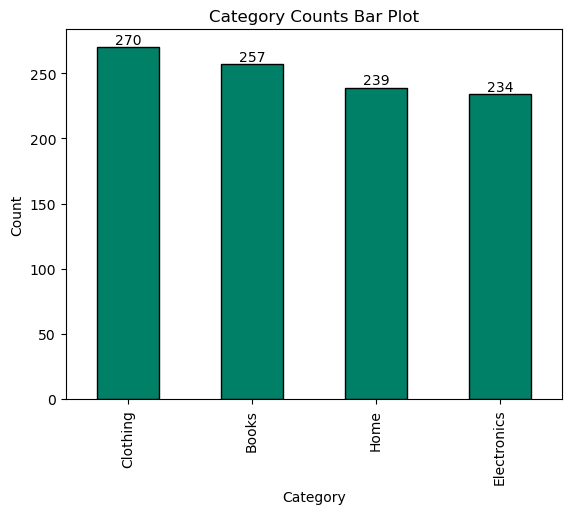

In [196]:
category_counts = data_oversample['Category'].value_counts()
ax = category_counts.plot(kind='bar', colormap='summer', edgecolor = "black")

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts Bar Plot')

for index, value in enumerate(category_counts):
    ax.text(index, value, str(value), ha='center', va='bottom')
plt.show()

In [228]:
quantity_ratio_category 


{'Clothing': 26.56, 'Books': 25.0, 'Home': 22.44, 'Electronics': 26.0}

In [226]:
category_counts_new = data_oversample['Category'].value_counts()
quantity_ratio_category_new = {
    "Clothing": round((category_counts_new["Clothing"] / category_counts_new.sum()) * 100, 2),
    "Books": round((category_counts_new["Books"] / category_counts_new.sum()) * 100, 2),
    "Home": round((category_counts_new["Home"] / category_counts_new.sum()) * 100, 2),
    "Electronics": round((category_counts_new["Electronics"] / category_counts_new.sum()) * 100, 2) 
}

quantity_ratio_category_new


{'Clothing': 27.0, 'Books': 25.7, 'Home': 23.9, 'Electronics': 23.4}

The ratio of each of the category has been maintained more or less. The new data set we have are data_oversample and data_undersample. We will continue work with the dataset called data_oversample, this is a personal preference. Because more data which has been imputed is better than less

#### Part 2

In [249]:
#creating a new feature called TotalSpent 
TotalSpent = data_oversample.groupby('CustomerID')['Price'].aggregate('sum').sort_values(ascending= False)
TotalSpent.head()

CustomerID
1033    5523.656524
1092    5502.158250
1090    5018.059171
1062    4789.408721
1099    4763.468902
Name: Price, dtype: float64

Customer 1033 is very valuable to the business

data_oversample 

In [270]:
popular_categories = data_oversample.groupby(['Category', 'Action'])['Quantity'].sum()   
table_format = popular_categories.reset_index()
print(table_format)

      Category       Action  Quantity
0        Books  Add to Cart       218
1        Books     Purchase       289
2        Books         View       247
3     Clothing  Add to Cart       372
4     Clothing     Purchase       190
5     Clothing         View       244
6  Electronics     Purchase       695
7         Home  Add to Cart       208
8         Home     Purchase       218
9         Home         View       294


In [259]:
conversion_rate = {
    "Books": round((popular_categories[1]/(popular_categories[0]+popular_categories[1])*100),2),
    "Clothing":round((popular_categories[4]/(popular_categories[3]+popular_categories[4])*100),2),
    "Electronics": round((popular_categories[6]/(popular_categories[6])*100),2),
    "Home": round((popular_categories[8]/(popular_categories[7]+popular_categories[8])*100),2),
}
conversion_rate


{'Books': 57.0, 'Clothing': 33.81, 'Electronics': 100.0, 'Home': 51.17}

The most popular items are electronics, because it has the highest conversion rate, the item with the second most highest conversion rate is for Books. Customers have the most doubt when purchasing Clothing 

In [262]:
print(mean_prices.sort_values(ascending=False))

Category
Books          263.292355
Electronics    261.835832
Home           259.914688
Clothing       246.535105
Name: Price, dtype: float64


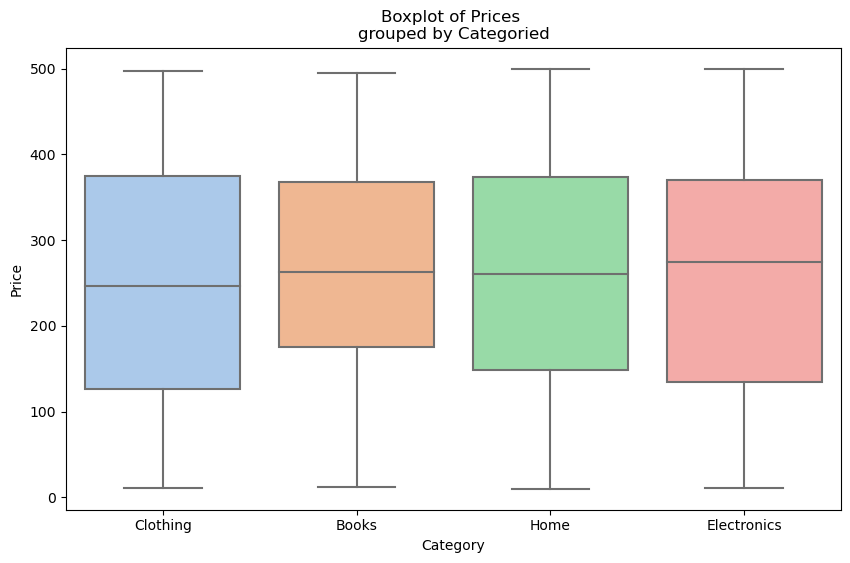

In [267]:
import seaborn as sns
sns.set_palette('pastel')
plt.figure(figsize= (10,6))
sns.boxplot(x = 'Category', y='Price', data = data_oversample)
plt.xlabel('Category')
plt.ylabel('Price')
plt.title('Boxplot of Prices \ngrouped by Categoried')
plt.xticks(rotation = 0)
plt.show()

It seems that the products in the Books and electronics category is the most expensive but clothing has as extensive price range. 

#### Part 3

#### Part 4